<a href="https://colab.research.google.com/github/PnZheng/DeepLearning/blob/main/GAN/Face_generation_using_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN

### 下载数据集

可利用wget进行数据集下载，或者自己手动下载并解压于对应目录下。




In [ ]:
!wget https://www.dropbox.com/s/rbajpdlh7efkdo1/male_female_face_images.zip
!unzip -q male_female_face_images.zip

一些常用的包引入，这里可能需要利用pip对torch_snippets进行下载。

In [1]:
!pip install torch_snippets
from torch_snippets import *
import torchvision
from torchvision import transforms
import torchvision.utils as vutils
import cv2, numpy as np, pandas as pd
device = "cuda" if torch.cuda.is_available() else "cpu"

2021-09-06 00:32:36.102 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


在下载的数据集中，为了只保留面部并丢弃图像中的其他细节，我们因此需要裁剪图像。

首先，我们将下载级联过滤器（ 利用OpenCV 在图像分析中的级联过滤器来过滤更多信息），这将有助于识别图像中的人脸：

In [2]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

在这里利用级联过滤器，来将数据集中人脸图像进行裁剪，整理到cropped_faces目录中去。

In [3]:
!mkdir cropped_faces
images = Glob('./face_images/females/*.jpg')+Glob('./face_images/males/*.jpg')
for i in range(len(images)):
    img = read(images[i],1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        img2 = img[y:(y+h),x:(x+w),:]
    cv2.imwrite('cropped_faces/'+str(i)+'.jpg',cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))

A subdirectory or file cropped_faces already exists.
2021-09-05 23:23:39.023 | INFO     | torch_snippets.paths:inner:24 - 14688 files found at ./face_images/females/*.jpg
2021-09-05 23:23:39.225 | INFO     | torch_snippets.paths:inner:24 - 13948 files found at ./face_images/males/*.jpg


KeyboardInterrupt: 

### 定义transform来预处理每一张图像

In [3]:
transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

### 定义一个Faces类，来对数据集进行管理：

In [4]:
class Faces(Dataset):
    def __init__(self, folder):
        super().__init__()
        self.folder = folder
        self.images = sorted(Glob(folder))
    def __len__(self):
        return len(self.images)
    def __getitem__(self, ix):
        image_path = self.images[ix]
        image = Image.open(image_path)
        image = transform(image)
        return image

### 实例化Faces类

In [5]:
ds = Faces(folder='cropped_faces/')

2021-09-06 00:32:45.137 | INFO     | torch_snippets.paths:inner:24 - 28636 files found at cropped_faces/


### 将Faces类加载到dataloader中

In [6]:
dataloader = DataLoader(ds, batch_size=64, shuffle=True)

### 权重初始化函数

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### 判别器定义
其中利用LeakyReLU函数当激活函数，并且利用BatchNorma2d进行归一化。


In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*2,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*4,64*8,4,2,1,bias=False),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*8,1,4,1,0,bias=False),
            nn.Sigmoid()
        )
        self.apply(weights_init)
    def forward(self, input): return self.model(input)

对判别器进行实例化，并安装torch_summary来将判别器中的网络结构和参数进行打印显示：

In [9]:
!pip install torch_summary
from torchsummary import summary
discriminator = Discriminator().to(device)
summary(discriminator,torch.zeros(1,3,64,64));

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 4, 4]           -

### 生成器的定义
这里利用的是ReLU函数当激活函数。并且利用ConvTranspose2d对进行逆卷计划操作。
其中输入的大小为：批大小 * 100 * 1 * 1。

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100,64*8,4,1,0,bias=False,),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*8,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*4,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*2,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64,3,4,2,1,bias=False),
            nn.Tanh()
        )
        self.apply(weights_init)
    def forward(self,input): return self.model(input)

实例化并显示其结构:

In [11]:
generator = Generator().to(device)
summary(generator,torch.zeros(1,100,1,1))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

### 定义训练过程中生成器和判别器的处理函数

这里利用squeeze操作将输出模型预测的值转换为：batchsize * 1 * 1 * 1。

In [12]:
def discriminator_train_step(real_data, fake_data):
    d_optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real.squeeze(), torch.ones(len(real_data)).to(device))
    error_real.backward()
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake.squeeze(), torch.zeros(len(fake_data)).to(device))
    error_fake.backward()
    d_optimizer.step()
    return error_real + error_fake

def generator_train_step(fake_data):
    g_optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = loss(prediction.squeeze(), torch.ones(len(real_data)).to(device))
    error.backward()
    g_optimizer.step()
    return error

### 实例化 并定义 优化器 和 损失函数

利用交叉熵做所损失函数，学习率为0.0002的Adam函数为优化器。

In [13]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
loss = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

### 训练模型
- 加载真实数据并通过生成网络生成虚假的数据。
- 利用discriminator_train_step训练判别器。
- 生成一组新的假数据，通过generator_train_step优化生成网络。

并且统计这些损失值，在最后进行展示，查看网络的优化的一个过程：

0
EPOCH: 1.000	d_loss: 0.500	g_loss: 8.114	(0.56s - 5.06s remaining)ng)
EPOCH: 1.000	d_loss: 0.515	g_loss: 7.046	(1.10s - 9.93s remaining)ng)
EPOCH: 1.000	d_loss: 0.475	g_loss: 6.897	(1.61s - 14.48s remaining)g)
EPOCH: 1.000	d_loss: 0.512	g_loss: 6.393	(2.17s - 19.50s remaining)g)
EPOCH: 1.000	d_loss: 0.499	g_loss: 6.588	(2.74s - 24.66s remaining)g)
EPOCH: 1.000	d_loss: 0.489	g_loss: 6.246	(3.27s - 29.41s remaining)g)
EPOCH: 1.000	d_loss: 0.490	g_loss: 6.434	(3.78s - 34.02s remaining)g)
EPOCH: 1.000	d_loss: 0.501	g_loss: 6.202	(4.30s - 38.72s remaining)g)
EPOCH: 1.000	d_loss: 0.533	g_loss: 6.508	(4.83s - 43.46s remaining)g)
EPOCH: 1.000	d_loss: 0.530	g_loss: 6.511	(5.35s - 48.11s remaining)g)
EPOCH: 1.000	d_loss: 0.532	g_loss: 6.319	(5.88s - 52.88s remaining)g)
EPOCH: 1.000	d_loss: 0.567	g_loss: 6.718	(6.40s - 57.59s remaining)ng)
EPOCH: 1.000	d_loss: 0.600	g_loss: 6.842	(6.93s - 62.41s remaining)g)
EPOCH: 1.000	d_loss: 0.574	g_loss: 6.648	(7.45s - 67.09s remaining)g)
EPOCH: 1.000	d_lo

EPOCH: 1.000	d_loss: 0.620	g_loss: 6.500	(67.09s - 603.77s remaining))
EPOCH: 1.000	d_loss: 0.628	g_loss: 6.487	(67.72s - 609.52s remaining))
EPOCH: 1.000	d_loss: 0.627	g_loss: 6.472	(68.37s - 615.32s remaining))
EPOCH: 1.000	d_loss: 0.625	g_loss: 6.478	(69.03s - 621.26s remaining))
EPOCH: 1.000	d_loss: 0.625	g_loss: 6.451	(69.68s - 627.09s remaining))
EPOCH: 1.000	d_loss: 0.629	g_loss: 6.481	(70.33s - 632.95s remaining)g)
EPOCH: 1.000	d_loss: 0.637	g_loss: 6.480	(70.94s - 638.44s remaining))
EPOCH: 1.000	d_loss: 0.634	g_loss: 6.451	(71.58s - 644.22s remaining))
EPOCH: 1.000	d_loss: 0.638	g_loss: 6.484	(72.20s - 649.79s remaining)g)
EPOCH: 1.000	d_loss: 0.640	g_loss: 6.503	(72.84s - 655.54s remaining))
EPOCH: 1.000	d_loss: 0.636	g_loss: 6.498	(73.48s - 661.34s remaining))
EPOCH: 1.000	d_loss: 0.633	g_loss: 6.483	(74.09s - 666.83s remaining))
EPOCH: 1.000	d_loss: 0.632	g_loss: 6.492	(74.75s - 672.75s remaining))
EPOCH: 1.000	d_loss: 0.630	g_loss: 6.487	(75.40s - 678.57s remaining))
EPOC

EPOCH: 1.000	d_loss: 0.604	g_loss: 6.400	(147.77s - 1329.91s remaining)
EPOCH: 1.000	d_loss: 0.603	g_loss: 6.396	(148.49s - 1336.41s remaining)
EPOCH: 1.000	d_loss: 0.602	g_loss: 6.388	(149.34s - 1344.07s remaining)
EPOCH: 1.000	d_loss: 0.602	g_loss: 6.390	(150.08s - 1350.75s remaining)
EPOCH: 1.000	d_loss: 0.602	g_loss: 6.379	(150.85s - 1357.62s remaining)
EPOCH: 1.000	d_loss: 0.603	g_loss: 6.391	(151.62s - 1364.57s remaining)
EPOCH: 1.000	d_loss: 0.604	g_loss: 6.388	(152.39s - 1371.53s remaining)
EPOCH: 1.000	d_loss: 0.602	g_loss: 6.375	(153.13s - 1378.13s remaining)
EPOCH: 1.000	d_loss: 0.604	g_loss: 6.397	(153.89s - 1384.99s remaining))
EPOCH: 1.000	d_loss: 0.609	g_loss: 6.403	(154.61s - 1391.45s remaining)
EPOCH: 1.000	d_loss: 0.608	g_loss: 6.395	(155.36s - 1398.23s remaining)
EPOCH: 1.000	d_loss: 0.608	g_loss: 6.394	(156.14s - 1405.28s remaining)
EPOCH: 1.000	d_loss: 0.607	g_loss: 6.391	(156.93s - 1412.37s remaining)
EPOCH: 1.000	d_loss: 0.606	g_loss: 6.385	(157.69s - 1419.18s re

EPOCH: 1.000	d_loss: 0.600	g_loss: 6.165	(238.26s - 2144.37s remaining)
EPOCH: 1.000	d_loss: 0.599	g_loss: 6.160	(239.13s - 2152.16s remaining)
EPOCH: 1.000	d_loss: 0.599	g_loss: 6.155	(239.95s - 2159.53s remaining)
EPOCH: 1.000	d_loss: 0.598	g_loss: 6.149	(240.79s - 2167.08s remaining)
EPOCH: 1.000	d_loss: 0.598	g_loss: 6.149	(241.63s - 2174.67s remaining)
EPOCH: 1.000	d_loss: 0.597	g_loss: 6.142	(242.45s - 2182.03s remaining)
EPOCH: 1.000	d_loss: 0.597	g_loss: 6.140	(243.25s - 2189.23s remaining)
EPOCH: 1.000	d_loss: 0.596	g_loss: 6.137	(244.11s - 2196.97s remaining)
EPOCH: 1.000	d_loss: 0.596	g_loss: 6.132	(244.94s - 2204.42s remaining)
EPOCH: 1.000	d_loss: 0.596	g_loss: 6.134	(245.83s - 2212.46s remaining)
EPOCH: 1.000	d_loss: 0.596	g_loss: 6.126	(246.66s - 2219.98s remaining)
EPOCH: 1.000	d_loss: 0.597	g_loss: 6.137	(247.54s - 2227.82s remaining))
EPOCH: 1.000	d_loss: 0.599	g_loss: 6.136	(248.40s - 2235.58s remaining)
EPOCH: 1.000	d_loss: 0.598	g_loss: 6.129	(249.26s - 2243.37s re

100%|██████████| 111/111 [00:00<00:00, 4828.94it/s]


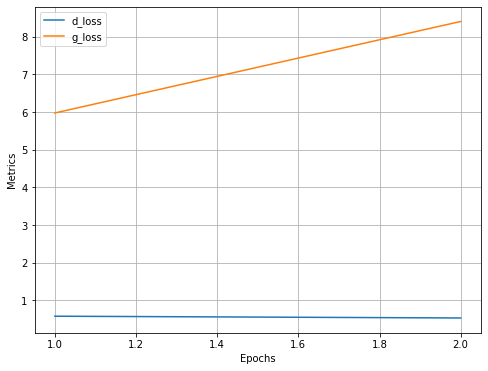

1
EPOCH: 2.000	d_loss: 0.883	g_loss: 5.281	(326.99s - 1307.95s remaining)
EPOCH: 2.000	d_loss: 0.977	g_loss: 6.642	(327.69s - 1310.77s remaining)
EPOCH: 2.000	d_loss: 0.870	g_loss: 6.879	(328.39s - 1313.57s remaining)
EPOCH: 2.000	d_loss: 0.775	g_loss: 6.184	(329.12s - 1316.47s remaining)
EPOCH: 2.000	d_loss: 0.740	g_loss: 6.171	(329.85s - 1319.39s remaining)
EPOCH: 2.000	d_loss: 0.663	g_loss: 6.147	(330.58s - 1322.32s remaining)
EPOCH: 2.000	d_loss: 0.608	g_loss: 5.890	(331.34s - 1325.38s remaining)
EPOCH: 2.000	d_loss: 0.594	g_loss: 5.843	(332.12s - 1328.47s remaining)
EPOCH: 2.000	d_loss: 0.588	g_loss: 5.614	(332.89s - 1331.57s remaining)
EPOCH: 2.000	d_loss: 0.592	g_loss: 5.810	(333.63s - 1334.53s remaining)
EPOCH: 2.000	d_loss: 0.602	g_loss: 5.656	(334.40s - 1337.58s remaining)
EPOCH: 2.000	d_loss: 0.583	g_loss: 5.572	(335.17s - 1340.67s remaining)
EPOCH: 2.000	d_loss: 0.572	g_loss: 5.502	(335.91s - 1343.65s remaining)
EPOCH: 2.000	d_loss: 0.560	g_loss: 5.453	(336.66s - 1346.65s r

EPOCH: 2.000	d_loss: 0.538	g_loss: 5.357	(439.44s - 1757.77s remaining)
EPOCH: 2.000	d_loss: 0.540	g_loss: 5.332	(440.51s - 1762.04s remaining)
EPOCH: 2.000	d_loss: 0.544	g_loss: 5.373	(441.62s - 1766.48s remaining))
EPOCH: 2.000	d_loss: 0.557	g_loss: 5.357	(442.69s - 1770.78s remaining)
EPOCH: 2.000	d_loss: 0.556	g_loss: 5.350	(443.76s - 1775.03s remaining)
EPOCH: 2.000	d_loss: 0.553	g_loss: 5.357	(444.89s - 1779.57s remaining)
EPOCH: 2.000	d_loss: 0.550	g_loss: 5.356	(445.95s - 1783.81s remaining)
EPOCH: 2.000	d_loss: 0.549	g_loss: 5.342	(447.11s - 1788.44s remaining)
EPOCH: 2.000	d_loss: 0.549	g_loss: 5.345	(448.21s - 1792.83s remaining)
EPOCH: 2.000	d_loss: 0.549	g_loss: 5.324	(449.22s - 1796.89s remaining)
EPOCH: 2.000	d_loss: 0.552	g_loss: 5.336	(450.32s - 1801.27s remaining)
EPOCH: 2.000	d_loss: 0.552	g_loss: 5.328	(451.56s - 1806.22s remaining)
EPOCH: 2.000	d_loss: 0.550	g_loss: 5.316	(452.73s - 1810.92s remaining)
EPOCH: 2.000	d_loss: 0.551	g_loss: 5.325	(453.97s - 1815.89s re

EPOCH: 2.000	d_loss: 0.517	g_loss: 5.217	(578.29s - 2313.14s remaining)
EPOCH: 2.000	d_loss: 0.516	g_loss: 5.215	(579.48s - 2317.92s remaining)
EPOCH: 2.000	d_loss: 0.516	g_loss: 5.214	(580.71s - 2322.86s remaining)
EPOCH: 2.000	d_loss: 0.516	g_loss: 5.204	(581.87s - 2327.50s remaining)
EPOCH: 2.000	d_loss: 0.516	g_loss: 5.209	(583.05s - 2332.18s remaining)
EPOCH: 2.000	d_loss: 0.515	g_loss: 5.207	(584.29s - 2337.15s remaining)
EPOCH: 2.000	d_loss: 0.514	g_loss: 5.197	(585.57s - 2342.26s remaining)
EPOCH: 2.000	d_loss: 0.514	g_loss: 5.204	(586.89s - 2347.58s remaining)
EPOCH: 2.000	d_loss: 0.514	g_loss: 5.195	(588.08s - 2352.33s remaining)
EPOCH: 2.000	d_loss: 0.514	g_loss: 5.200	(589.30s - 2357.22s remaining)
EPOCH: 2.000	d_loss: 0.514	g_loss: 5.200	(590.66s - 2362.63s remaining)
EPOCH: 2.000	d_loss: 0.513	g_loss: 5.198	(591.95s - 2367.81s remaining)
EPOCH: 2.000	d_loss: 0.512	g_loss: 5.196	(593.03s - 2372.12s remaining)
EPOCH: 2.000	d_loss: 0.511	g_loss: 5.196	(594.08s - 2376.32s rem

EPOCH: 2.000	d_loss: 0.514	g_loss: 5.102	(709.97s - 2839.88s remaining)
EPOCH: 2.000	d_loss: 0.514	g_loss: 5.098	(711.02s - 2844.07s remaining)
EPOCH: 2.000	d_loss: 0.513	g_loss: 5.098	(712.14s - 2848.58s remaining)
EPOCH: 2.000	d_loss: 0.513	g_loss: 5.094	(713.25s - 2853.00s remaining)
EPOCH: 2.000	d_loss: 0.513	g_loss: 5.090	(714.46s - 2857.83s remaining)
EPOCH: 2.000	d_loss: 0.512	g_loss: 5.096	(715.58s - 2862.34s remaining)
EPOCH: 2.000	d_loss: 0.513	g_loss: 5.092	(716.71s - 2866.84s remaining)
EPOCH: 2.000	d_loss: 0.512	g_loss: 5.096	(717.74s - 2870.96s remaining)
EPOCH: 2.000	d_loss: 0.512	g_loss: 5.095	(718.83s - 2875.32s remaining)
EPOCH: 2.000	d_loss: 0.511	g_loss: 5.098	(719.68s - 2878.72s remaining)
EPOCH: 2.000	d_loss: 0.510	g_loss: 5.097	(720.77s - 2883.08s remaining)
EPOCH: 2.000	d_loss: 0.510	g_loss: 5.094	(721.94s - 2887.77s remaining)
EPOCH: 2.000	d_loss: 0.510	g_loss: 5.096	(723.12s - 2892.46s remaining)
EPOCH: 2.000	d_loss: 0.511	g_loss: 5.084	(724.01s - 2896.03s rem

100%|██████████| 111/111 [00:00<00:00, 2473.29it/s]

EPOCH: 2.000	d_loss: 0.529	g_loss: 5.042	(827.64s - 3310.55s remaining)


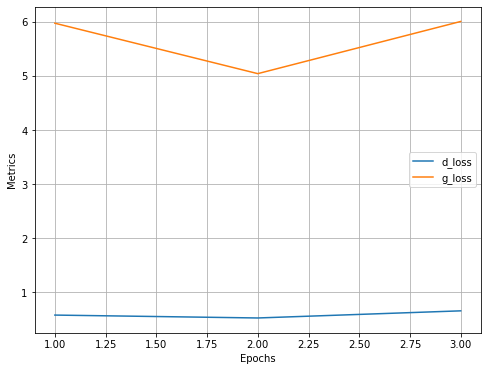

2
EPOCH: 3.000	d_loss: 0.479	g_loss: 5.720	(828.53s - 1933.25s remaining)
EPOCH: 3.000	d_loss: 0.475	g_loss: 4.651	(829.06s - 1934.48s remaining)
EPOCH: 3.000	d_loss: 0.599	g_loss: 5.796	(829.62s - 1935.79s remaining)
EPOCH: 3.000	d_loss: 0.875	g_loss: 5.271	(830.19s - 1937.11s remaining)
EPOCH: 3.000	d_loss: 0.797	g_loss: 4.973	(830.76s - 1938.44s remaining)
EPOCH: 3.000	d_loss: 0.738	g_loss: 5.155	(831.35s - 1939.82s remaining)
EPOCH: 3.000	d_loss: 0.747	g_loss: 4.740	(831.95s - 1941.22s remaining)
EPOCH: 3.000	d_loss: 0.779	g_loss: 4.990	(832.55s - 1942.61s remaining)
EPOCH: 3.000	d_loss: 0.767	g_loss: 4.983	(833.12s - 1943.95s remaining)
EPOCH: 3.000	d_loss: 0.725	g_loss: 4.902	(833.71s - 1945.32s remaining)
EPOCH: 3.000	d_loss: 0.692	g_loss: 4.869	(834.29s - 1946.68s remaining)
EPOCH: 3.000	d_loss: 0.666	g_loss: 4.775	(834.89s - 1948.08s remaining)
EPOCH: 3.000	d_loss: 0.647	g_loss: 4.685	(835.49s - 1949.48s remaining)
EPOCH: 3.000	d_loss: 0.642	g_loss: 4.567	(836.11s - 1950.93s r

EPOCH: 3.000	d_loss: 0.547	g_loss: 4.168	(914.14s - 2133.00s remaining)
EPOCH: 3.000	d_loss: 0.546	g_loss: 4.158	(915.00s - 2134.99s remaining)
EPOCH: 3.000	d_loss: 0.545	g_loss: 4.154	(915.86s - 2137.00s remaining)
EPOCH: 3.000	d_loss: 0.544	g_loss: 4.145	(916.71s - 2138.99s remaining)
EPOCH: 3.000	d_loss: 0.543	g_loss: 4.141	(917.58s - 2141.01s remaining)
EPOCH: 3.000	d_loss: 0.542	g_loss: 4.135	(918.44s - 2143.02s remaining)
EPOCH: 3.000	d_loss: 0.540	g_loss: 4.128	(919.33s - 2145.10s remaining)
EPOCH: 3.000	d_loss: 0.540	g_loss: 4.128	(920.21s - 2147.15s remaining)
EPOCH: 3.000	d_loss: 0.539	g_loss: 4.117	(921.07s - 2149.16s remaining)
EPOCH: 3.000	d_loss: 0.539	g_loss: 4.120	(921.92s - 2151.15s remaining)
EPOCH: 3.000	d_loss: 0.537	g_loss: 4.114	(922.77s - 2153.14s remaining)
EPOCH: 3.000	d_loss: 0.536	g_loss: 4.112	(923.62s - 2155.12s remaining)
EPOCH: 3.000	d_loss: 0.534	g_loss: 4.117	(924.49s - 2157.15s remaining)
EPOCH: 3.000	d_loss: 0.531	g_loss: 4.114	(925.35s - 2159.16s rem

EPOCH: 3.000	d_loss: 0.506	g_loss: 4.113	(1012.70s - 2362.97s remaining)
EPOCH: 3.000	d_loss: 0.508	g_loss: 4.105	(1013.59s - 2365.04s remaining)
EPOCH: 3.000	d_loss: 0.508	g_loss: 4.116	(1014.47s - 2367.11s remaining)
EPOCH: 3.000	d_loss: 0.509	g_loss: 4.110	(1015.36s - 2369.17s remaining)
EPOCH: 3.000	d_loss: 0.509	g_loss: 4.105	(1016.24s - 2371.24s remaining)
EPOCH: 3.000	d_loss: 0.509	g_loss: 4.115	(1017.12s - 2373.28s remaining)
EPOCH: 3.000	d_loss: 0.510	g_loss: 4.110	(1017.99s - 2375.31s remaining)
EPOCH: 3.000	d_loss: 0.509	g_loss: 4.104	(1018.86s - 2377.34s remaining)
EPOCH: 3.000	d_loss: 0.510	g_loss: 4.118	(1019.75s - 2379.42s remaining)
EPOCH: 3.000	d_loss: 0.512	g_loss: 4.109	(1020.64s - 2381.49s remaining)
EPOCH: 3.000	d_loss: 0.514	g_loss: 4.116	(1021.52s - 2383.55s remaining)
EPOCH: 3.000	d_loss: 0.513	g_loss: 4.115	(1022.41s - 2385.61s remaining)
EPOCH: 3.000	d_loss: 0.513	g_loss: 4.110	(1023.29s - 2387.68s remaining)
EPOCH: 3.000	d_loss: 0.513	g_loss: 4.114	(1024.17s 

EPOCH: 3.000	d_loss: 0.530	g_loss: 4.117	(1112.61s - 2596.09s remaining)
EPOCH: 3.000	d_loss: 0.529	g_loss: 4.115	(1113.49s - 2598.13s remaining)
EPOCH: 3.000	d_loss: 0.529	g_loss: 4.119	(1114.36s - 2600.18s remaining)
EPOCH: 3.000	d_loss: 0.529	g_loss: 4.116	(1115.25s - 2602.25s remaining)
EPOCH: 3.000	d_loss: 0.529	g_loss: 4.121	(1116.13s - 2604.31s remaining)
EPOCH: 3.000	d_loss: 0.529	g_loss: 4.117	(1117.03s - 2606.41s remaining)
EPOCH: 3.000	d_loss: 0.530	g_loss: 4.121	(1117.90s - 2608.44s remaining)
EPOCH: 3.000	d_loss: 0.529	g_loss: 4.119	(1118.78s - 2610.50s remaining)
EPOCH: 3.000	d_loss: 0.529	g_loss: 4.116	(1119.68s - 2612.58s remaining)
EPOCH: 3.000	d_loss: 0.529	g_loss: 4.116	(1120.58s - 2614.68s remaining)
EPOCH: 3.000	d_loss: 0.528	g_loss: 4.114	(1121.46s - 2616.74s remaining)
EPOCH: 3.000	d_loss: 0.528	g_loss: 4.113	(1122.34s - 2618.80s remaining)
EPOCH: 3.000	d_loss: 0.528	g_loss: 4.116	(1123.22s - 2620.84s remaining)
EPOCH: 3.000	d_loss: 0.528	g_loss: 4.112	(1124.10s 

100%|██████████| 111/111 [00:00<00:00, 877.96it/s]

EPOCH: 3.000	d_loss: 0.523	g_loss: 4.084	(1206.94s - 2816.19s remaining)


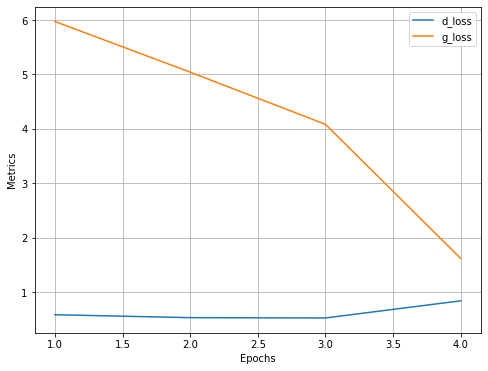

3
EPOCH: 4.000	d_loss: 0.927	g_loss: 4.375	(1208.53s - 1812.79s remaining)
EPOCH: 4.000	d_loss: 0.890	g_loss: 3.682	(1209.44s - 1814.17s remaining)
EPOCH: 4.000	d_loss: 0.860	g_loss: 4.268	(1210.36s - 1815.54s remaining)
EPOCH: 4.000	d_loss: 0.765	g_loss: 4.360	(1211.29s - 1816.93s remaining)
EPOCH: 4.000	d_loss: 0.704	g_loss: 4.038	(1212.22s - 1818.33s remaining)
EPOCH: 4.000	d_loss: 0.699	g_loss: 4.340	(1213.12s - 1819.68s remaining)
EPOCH: 4.000	d_loss: 0.740	g_loss: 3.997	(1214.06s - 1821.09s remaining)
EPOCH: 4.000	d_loss: 0.785	g_loss: 4.438	(1214.95s - 1822.43s remaining)
EPOCH: 4.000	d_loss: 0.813	g_loss: 4.299	(1215.86s - 1823.80s remaining)
EPOCH: 4.000	d_loss: 0.808	g_loss: 4.435	(1216.81s - 1825.22s remaining)
EPOCH: 4.000	d_loss: 0.762	g_loss: 4.495	(1217.73s - 1826.59s remaining)
EPOCH: 4.000	d_loss: 0.743	g_loss: 4.324	(1218.63s - 1827.94s remaining)
EPOCH: 4.000	d_loss: 0.747	g_loss: 4.369	(1219.51s - 1829.26s remaining)
EPOCH: 4.000	d_loss: 0.740	g_loss: 4.271	(1220.40

EPOCH: 4.000	d_loss: 0.549	g_loss: 3.844	(1325.51s - 1988.27s remaining)
EPOCH: 4.000	d_loss: 0.547	g_loss: 3.836	(1326.39s - 1989.59s remaining)
EPOCH: 4.000	d_loss: 0.546	g_loss: 3.840	(1327.28s - 1990.92s remaining)
EPOCH: 4.000	d_loss: 0.545	g_loss: 3.831	(1328.16s - 1992.25s remaining)
EPOCH: 4.000	d_loss: 0.545	g_loss: 3.837	(1329.06s - 1993.59s remaining)
EPOCH: 4.000	d_loss: 0.545	g_loss: 3.826	(1329.95s - 1994.93s remaining)
EPOCH: 4.000	d_loss: 0.543	g_loss: 3.822	(1330.83s - 1996.25s remaining)
EPOCH: 4.000	d_loss: 0.541	g_loss: 3.817	(1331.70s - 1997.55s remaining)
EPOCH: 4.000	d_loss: 0.539	g_loss: 3.808	(1332.59s - 1998.89s remaining)
EPOCH: 4.000	d_loss: 0.537	g_loss: 3.813	(1333.46s - 2000.19s remaining)
EPOCH: 4.000	d_loss: 0.538	g_loss: 3.796	(1334.35s - 2001.53s remaining)
EPOCH: 4.000	d_loss: 0.540	g_loss: 3.818	(1335.23s - 2002.85s remaining)
EPOCH: 4.000	d_loss: 0.541	g_loss: 3.817	(1336.11s - 2004.17s remaining)
EPOCH: 4.000	d_loss: 0.538	g_loss: 3.811	(1336.99s 

EPOCH: 4.000	d_loss: 0.583	g_loss: 3.817	(1425.29s - 2137.94s remaining)
EPOCH: 4.000	d_loss: 0.582	g_loss: 3.809	(1426.17s - 2139.26s remaining)
EPOCH: 4.000	d_loss: 0.584	g_loss: 3.823	(1427.05s - 2140.58s remaining)
EPOCH: 4.000	d_loss: 0.584	g_loss: 3.825	(1427.93s - 2141.90s remaining)
EPOCH: 4.000	d_loss: 0.582	g_loss: 3.822	(1428.81s - 2143.21s remaining)
EPOCH: 4.000	d_loss: 0.581	g_loss: 3.825	(1429.68s - 2144.52s remaining)
EPOCH: 4.000	d_loss: 0.580	g_loss: 3.825	(1430.56s - 2145.85s remaining)
EPOCH: 4.000	d_loss: 0.580	g_loss: 3.821	(1431.45s - 2147.17s remaining)
EPOCH: 4.000	d_loss: 0.580	g_loss: 3.819	(1432.33s - 2148.50s remaining)
EPOCH: 4.000	d_loss: 0.579	g_loss: 3.815	(1433.21s - 2149.82s remaining)
EPOCH: 4.000	d_loss: 0.578	g_loss: 3.817	(1434.10s - 2151.14s remaining)
EPOCH: 4.000	d_loss: 0.578	g_loss: 3.814	(1434.97s - 2152.46s remaining)
EPOCH: 4.000	d_loss: 0.577	g_loss: 3.809	(1435.85s - 2153.78s remaining)
EPOCH: 4.000	d_loss: 0.577	g_loss: 3.815	(1436.72s 

EPOCH: 4.000	d_loss: 0.567	g_loss: 3.771	(1525.30s - 2287.95s remaining)
EPOCH: 4.000	d_loss: 0.567	g_loss: 3.769	(1526.19s - 2289.29s remaining)
EPOCH: 4.000	d_loss: 0.566	g_loss: 3.767	(1527.08s - 2290.62s remaining)
EPOCH: 4.000	d_loss: 0.566	g_loss: 3.770	(1527.97s - 2291.96s remaining)
EPOCH: 4.000	d_loss: 0.566	g_loss: 3.764	(1528.86s - 2293.29s remaining)
EPOCH: 4.000	d_loss: 0.567	g_loss: 3.771	(1529.75s - 2294.63s remaining)
EPOCH: 4.000	d_loss: 0.568	g_loss: 3.768	(1530.64s - 2295.96s remaining)
EPOCH: 4.000	d_loss: 0.567	g_loss: 3.766	(1531.52s - 2297.29s remaining)
EPOCH: 4.000	d_loss: 0.567	g_loss: 3.770	(1532.40s - 2298.61s remaining)
EPOCH: 4.000	d_loss: 0.568	g_loss: 3.763	(1533.29s - 2299.94s remaining)
EPOCH: 4.000	d_loss: 0.569	g_loss: 3.768	(1534.18s - 2301.27s remaining)
EPOCH: 4.000	d_loss: 0.569	g_loss: 3.764	(1535.07s - 2302.60s remaining)
EPOCH: 4.000	d_loss: 0.569	g_loss: 3.767	(1535.95s - 2303.92s remaining)
EPOCH: 4.000	d_loss: 0.568	g_loss: 3.770	(1536.84s 

100%|██████████| 111/111 [00:00<00:00, 959.17it/s]

EPOCH: 4.000	d_loss: 0.585	g_loss: 3.741	(1621.08s - 2431.62s remaining)


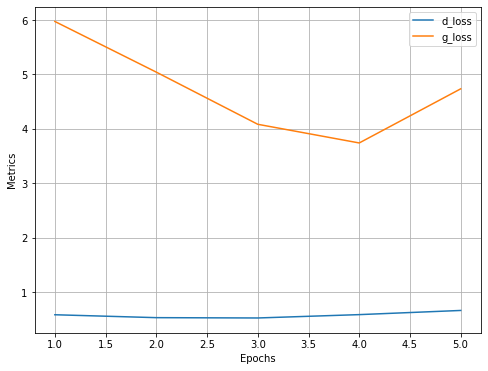

4
EPOCH: 5.000	d_loss: 0.509	g_loss: 4.534	(1622.36s - 1622.36s remaining)
EPOCH: 5.000	d_loss: 0.573	g_loss: 3.823	(1623.25s - 1623.25s remaining)
EPOCH: 5.000	d_loss: 0.616	g_loss: 4.149	(1624.14s - 1624.14s remaining)
EPOCH: 5.000	d_loss: 0.591	g_loss: 4.096	(1625.02s - 1625.02s remaining)
EPOCH: 5.000	d_loss: 0.574	g_loss: 3.848	(1625.91s - 1625.91s remaining)
EPOCH: 5.000	d_loss: 0.560	g_loss: 3.975	(1626.79s - 1626.79s remaining)
EPOCH: 5.000	d_loss: 0.563	g_loss: 3.880	(1627.69s - 1627.69s remaining)
EPOCH: 5.000	d_loss: 0.564	g_loss: 3.738	(1628.57s - 1628.57s remaining)
EPOCH: 5.000	d_loss: 0.553	g_loss: 3.787	(1629.45s - 1629.45s remaining)
EPOCH: 5.000	d_loss: 0.546	g_loss: 3.689	(1630.34s - 1630.34s remaining)
EPOCH: 5.000	d_loss: 0.543	g_loss: 3.729	(1631.22s - 1631.22s remaining)
EPOCH: 5.000	d_loss: 0.537	g_loss: 3.683	(1632.11s - 1632.11s remaining)
EPOCH: 5.000	d_loss: 0.528	g_loss: 3.647	(1633.01s - 1633.01s remaining)
EPOCH: 5.000	d_loss: 0.534	g_loss: 3.583	(1633.89

EPOCH: 5.000	d_loss: 0.532	g_loss: 3.629	(1739.71s - 1739.71s remaining)
EPOCH: 5.000	d_loss: 0.531	g_loss: 3.631	(1740.95s - 1740.95s remaining)
EPOCH: 5.000	d_loss: 0.530	g_loss: 3.629	(1742.18s - 1742.18s remaining)
EPOCH: 5.000	d_loss: 0.528	g_loss: 3.621	(1743.42s - 1743.42s remaining)
EPOCH: 5.000	d_loss: 0.527	g_loss: 3.619	(1744.65s - 1744.65s remaining)
EPOCH: 5.000	d_loss: 0.526	g_loss: 3.613	(1745.87s - 1745.87s remaining)
EPOCH: 5.000	d_loss: 0.526	g_loss: 3.614	(1747.09s - 1747.09s remaining)
EPOCH: 5.000	d_loss: 0.525	g_loss: 3.601	(1748.34s - 1748.34s remaining)
EPOCH: 5.000	d_loss: 0.526	g_loss: 3.612	(1749.59s - 1749.59s remaining)
EPOCH: 5.000	d_loss: 0.526	g_loss: 3.601	(1750.81s - 1750.81s remaining)
EPOCH: 5.000	d_loss: 0.526	g_loss: 3.597	(1752.04s - 1752.04s remaining)
EPOCH: 5.000	d_loss: 0.525	g_loss: 3.604	(1753.27s - 1753.27s remaining)
EPOCH: 5.000	d_loss: 0.525	g_loss: 3.588	(1754.49s - 1754.49s remaining)
EPOCH: 5.000	d_loss: 0.527	g_loss: 3.606	(1755.72s 

EPOCH: 5.000	d_loss: 0.580	g_loss: 3.600	(1857.81s - 1857.81s remaining)
EPOCH: 5.000	d_loss: 0.579	g_loss: 3.596	(1858.69s - 1858.69s remaining)
EPOCH: 5.000	d_loss: 0.579	g_loss: 3.595	(1859.58s - 1859.58s remaining)
EPOCH: 5.000	d_loss: 0.579	g_loss: 3.593	(1860.47s - 1860.47s remaining)
EPOCH: 5.000	d_loss: 0.579	g_loss: 3.588	(1861.36s - 1861.36s remaining)
EPOCH: 5.000	d_loss: 0.578	g_loss: 3.594	(1862.26s - 1862.26s remaining)
EPOCH: 5.000	d_loss: 0.577	g_loss: 3.592	(1863.14s - 1863.14s remaining)
EPOCH: 5.000	d_loss: 0.576	g_loss: 3.589	(1864.03s - 1864.03s remaining)
EPOCH: 5.000	d_loss: 0.575	g_loss: 3.593	(1864.94s - 1864.94s remaining)
EPOCH: 5.000	d_loss: 0.575	g_loss: 3.589	(1865.82s - 1865.82s remaining)
EPOCH: 5.000	d_loss: 0.574	g_loss: 3.588	(1866.71s - 1866.71s remaining)
EPOCH: 5.000	d_loss: 0.573	g_loss: 3.589	(1867.60s - 1867.60s remaining)
EPOCH: 5.000	d_loss: 0.573	g_loss: 3.586	(1868.49s - 1868.49s remaining)
EPOCH: 5.000	d_loss: 0.572	g_loss: 3.588	(1869.38s 

EPOCH: 5.000	d_loss: 0.579	g_loss: 3.547	(1958.35s - 1958.35s remaining)
EPOCH: 5.000	d_loss: 0.579	g_loss: 3.542	(1959.24s - 1959.24s remaining)
EPOCH: 5.000	d_loss: 0.580	g_loss: 3.546	(1960.12s - 1960.12s remaining)
EPOCH: 5.000	d_loss: 0.578	g_loss: 3.551	(1961.03s - 1961.03s remaining)
EPOCH: 5.000	d_loss: 0.579	g_loss: 3.543	(1961.93s - 1961.93s remaining)
EPOCH: 5.000	d_loss: 0.582	g_loss: 3.548	(1962.81s - 1962.81s remaining)
EPOCH: 5.000	d_loss: 0.582	g_loss: 3.547	(1963.70s - 1963.70s remaining)
EPOCH: 5.000	d_loss: 0.582	g_loss: 3.545	(1964.58s - 1964.58s remaining)
EPOCH: 5.000	d_loss: 0.582	g_loss: 3.551	(1965.48s - 1965.48s remaining)
EPOCH: 5.000	d_loss: 0.582	g_loss: 3.547	(1966.36s - 1966.36s remaining)
EPOCH: 5.000	d_loss: 0.582	g_loss: 3.548	(1967.24s - 1967.24s remaining)
EPOCH: 5.000	d_loss: 0.581	g_loss: 3.550	(1968.12s - 1968.12s remaining)
EPOCH: 5.000	d_loss: 0.581	g_loss: 3.549	(1969.01s - 1969.01s remaining)
EPOCH: 5.000	d_loss: 0.580	g_loss: 3.551	(1969.89s 

100%|██████████| 111/111 [00:00<00:00, 869.51it/s]

EPOCH: 5.000	d_loss: 0.600	g_loss: 3.536	(2054.08s - 2054.08s remaining)


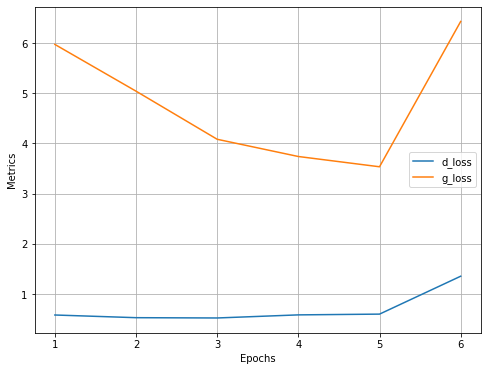

5
EPOCH: 6.000	d_loss: 1.212	g_loss: 4.756	(2055.34s - 1370.23s remaining)
EPOCH: 6.000	d_loss: 1.146	g_loss: 4.803	(2056.23s - 1370.82s remaining)
EPOCH: 6.000	d_loss: 0.990	g_loss: 4.600	(2057.13s - 1371.42s remaining)
EPOCH: 6.000	d_loss: 0.907	g_loss: 4.274	(2058.02s - 1372.01s remaining)
EPOCH: 6.000	d_loss: 0.924	g_loss: 4.363	(2058.92s - 1372.61s remaining)
EPOCH: 6.000	d_loss: 0.925	g_loss: 4.056	(2059.81s - 1373.21s remaining)
EPOCH: 6.000	d_loss: 0.955	g_loss: 4.242	(2060.71s - 1373.81s remaining)
EPOCH: 6.000	d_loss: 0.969	g_loss: 4.038	(2061.59s - 1374.39s remaining)
EPOCH: 6.000	d_loss: 0.956	g_loss: 4.016	(2062.49s - 1374.99s remaining)
EPOCH: 6.000	d_loss: 0.914	g_loss: 4.010	(2063.39s - 1375.59s remaining)
EPOCH: 6.000	d_loss: 0.880	g_loss: 3.901	(2064.27s - 1376.18s remaining)
EPOCH: 6.000	d_loss: 0.853	g_loss: 3.871	(2065.16s - 1376.78s remaining)
EPOCH: 6.000	d_loss: 0.838	g_loss: 3.865	(2066.05s - 1377.37s remaining)
EPOCH: 6.000	d_loss: 0.820	g_loss: 3.776	(2066.94

EPOCH: 6.000	d_loss: 0.593	g_loss: 3.246	(2156.13s - 1437.42s remaining)
EPOCH: 6.000	d_loss: 0.595	g_loss: 3.264	(2157.03s - 1438.02s remaining)
EPOCH: 6.000	d_loss: 0.596	g_loss: 3.258	(2157.93s - 1438.62s remaining)
EPOCH: 6.000	d_loss: 0.595	g_loss: 3.261	(2158.84s - 1439.22s remaining)
EPOCH: 6.000	d_loss: 0.593	g_loss: 3.266	(2159.74s - 1439.83s remaining)
EPOCH: 6.000	d_loss: 0.592	g_loss: 3.259	(2160.67s - 1440.45s remaining)
EPOCH: 6.000	d_loss: 0.591	g_loss: 3.255	(2161.58s - 1441.05s remaining)
EPOCH: 6.000	d_loss: 0.590	g_loss: 3.260	(2162.49s - 1441.66s remaining)
EPOCH: 6.000	d_loss: 0.589	g_loss: 3.250	(2163.39s - 1442.26s remaining)
EPOCH: 6.000	d_loss: 0.589	g_loss: 3.256	(2164.30s - 1442.87s remaining)
EPOCH: 6.000	d_loss: 0.589	g_loss: 3.247	(2165.21s - 1443.47s remaining)
EPOCH: 6.000	d_loss: 0.589	g_loss: 3.258	(2166.10s - 1444.07s remaining)
EPOCH: 6.000	d_loss: 0.589	g_loss: 3.244	(2167.01s - 1444.67s remaining)
EPOCH: 6.000	d_loss: 0.592	g_loss: 3.262	(2167.91s 

EPOCH: 6.000	d_loss: 0.604	g_loss: 3.280	(2273.41s - 1515.60s remaining)
EPOCH: 6.000	d_loss: 0.606	g_loss: 3.272	(2274.63s - 1516.42s remaining)
EPOCH: 6.000	d_loss: 0.607	g_loss: 3.282	(2275.86s - 1517.24s remaining)
EPOCH: 6.000	d_loss: 0.607	g_loss: 3.277	(2277.08s - 1518.06s remaining)
EPOCH: 6.000	d_loss: 0.608	g_loss: 3.289	(2278.31s - 1518.87s remaining)
EPOCH: 6.000	d_loss: 0.611	g_loss: 3.281	(2279.54s - 1519.69s remaining)
EPOCH: 6.000	d_loss: 0.612	g_loss: 3.287	(2280.77s - 1520.51s remaining)
EPOCH: 6.000	d_loss: 0.611	g_loss: 3.292	(2282.01s - 1521.34s remaining)
EPOCH: 6.000	d_loss: 0.610	g_loss: 3.284	(2283.24s - 1522.16s remaining)
EPOCH: 6.000	d_loss: 0.611	g_loss: 3.291	(2284.49s - 1523.00s remaining)
EPOCH: 6.000	d_loss: 0.612	g_loss: 3.282	(2285.71s - 1523.81s remaining)
EPOCH: 6.000	d_loss: 0.613	g_loss: 3.287	(2286.93s - 1524.62s remaining)
EPOCH: 6.000	d_loss: 0.612	g_loss: 3.285	(2288.15s - 1525.43s remaining)
EPOCH: 6.000	d_loss: 0.612	g_loss: 3.282	(2289.37s 

EPOCH: 6.000	d_loss: 0.617	g_loss: 3.265	(2397.10s - 1598.07s remaining)
EPOCH: 6.000	d_loss: 0.617	g_loss: 3.268	(2398.00s - 1598.67s remaining)
EPOCH: 6.000	d_loss: 0.617	g_loss: 3.265	(2398.88s - 1599.26s remaining)
EPOCH: 6.000	d_loss: 0.617	g_loss: 3.271	(2399.77s - 1599.85s remaining)
EPOCH: 6.000	d_loss: 0.617	g_loss: 3.269	(2400.65s - 1600.43s remaining)
EPOCH: 6.000	d_loss: 0.617	g_loss: 3.270	(2401.57s - 1601.05s remaining)
EPOCH: 6.000	d_loss: 0.617	g_loss: 3.272	(2402.47s - 1601.64s remaining)
EPOCH: 6.000	d_loss: 0.616	g_loss: 3.270	(2403.36s - 1602.24s remaining)
EPOCH: 6.000	d_loss: 0.616	g_loss: 3.272	(2404.24s - 1602.83s remaining)
EPOCH: 6.000	d_loss: 0.615	g_loss: 3.270	(2405.12s - 1603.41s remaining)
EPOCH: 6.000	d_loss: 0.615	g_loss: 3.270	(2406.01s - 1604.01s remaining)
EPOCH: 6.000	d_loss: 0.616	g_loss: 3.271	(2406.90s - 1604.60s remaining)
EPOCH: 6.000	d_loss: 0.616	g_loss: 3.266	(2407.78s - 1605.19s remaining)
EPOCH: 6.000	d_loss: 0.617	g_loss: 3.274	(2408.66s 

 44%|████▍     | 49/111 [00:00<00:00, 481.68it/s]

EPOCH: 6.000	d_loss: 0.621	g_loss: 3.249	(2492.99s - 1662.00s remaining)


100%|██████████| 111/111 [00:00<00:00, 517.10it/s]


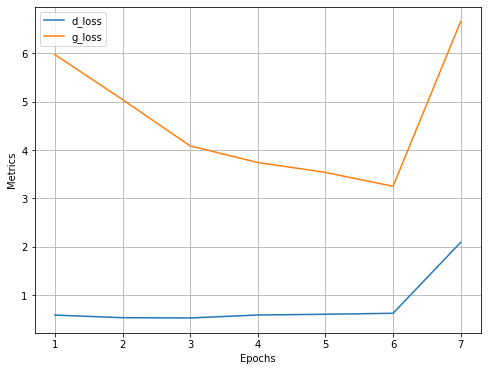

6
EPOCH: 7.000	d_loss: 2.193	g_loss: 3.793	(2494.44s - 1069.04s remaining)
EPOCH: 7.000	d_loss: 2.044	g_loss: 4.443	(2495.33s - 1069.43s remaining)
EPOCH: 7.000	d_loss: 1.716	g_loss: 4.374	(2496.25s - 1069.82s remaining)
EPOCH: 7.000	d_loss: 1.464	g_loss: 4.016	(2497.16s - 1070.21s remaining)
EPOCH: 7.000	d_loss: 1.376	g_loss: 4.074	(2498.09s - 1070.61s remaining)
EPOCH: 7.000	d_loss: 1.357	g_loss: 3.695	(2499.01s - 1071.00s remaining)
EPOCH: 7.000	d_loss: 1.377	g_loss: 3.987	(2499.91s - 1071.39s remaining)
EPOCH: 7.000	d_loss: 1.394	g_loss: 3.818	(2500.82s - 1071.78s remaining)
EPOCH: 7.000	d_loss: 1.333	g_loss: 3.737	(2501.73s - 1072.17s remaining)
EPOCH: 7.000	d_loss: 1.262	g_loss: 3.716	(2502.65s - 1072.56s remaining)
EPOCH: 7.000	d_loss: 1.197	g_loss: 3.706	(2503.55s - 1072.95s remaining)
EPOCH: 7.000	d_loss: 1.167	g_loss: 3.630	(2504.49s - 1073.35s remaining)
EPOCH: 7.000	d_loss: 1.144	g_loss: 3.660	(2505.41s - 1073.75s remaining)
EPOCH: 7.000	d_loss: 1.102	g_loss: 3.609	(2506.31

EPOCH: 7.000	d_loss: 0.628	g_loss: 3.138	(2595.36s - 1112.30s remaining)
EPOCH: 7.000	d_loss: 0.632	g_loss: 3.119	(2596.25s - 1112.68s remaining)
EPOCH: 7.000	d_loss: 0.637	g_loss: 3.139	(2597.14s - 1113.06s remaining)
EPOCH: 7.000	d_loss: 0.640	g_loss: 3.131	(2598.03s - 1113.44s remaining)
EPOCH: 7.000	d_loss: 0.640	g_loss: 3.135	(2599.01s - 1113.86s remaining)
EPOCH: 7.000	d_loss: 0.638	g_loss: 3.134	(2600.23s - 1114.38s remaining)
EPOCH: 7.000	d_loss: 0.636	g_loss: 3.128	(2601.45s - 1114.91s remaining)
EPOCH: 7.000	d_loss: 0.636	g_loss: 3.131	(2602.69s - 1115.44s remaining)
EPOCH: 7.000	d_loss: 0.634	g_loss: 3.132	(2603.95s - 1115.98s remaining)
EPOCH: 7.000	d_loss: 0.633	g_loss: 3.131	(2605.18s - 1116.51s remaining)
EPOCH: 7.000	d_loss: 0.631	g_loss: 3.127	(2606.41s - 1117.03s remaining)
EPOCH: 7.000	d_loss: 0.631	g_loss: 3.112	(2607.63s - 1117.56s remaining)
EPOCH: 7.000	d_loss: 0.632	g_loss: 3.120	(2608.86s - 1118.08s remaining)
EPOCH: 7.000	d_loss: 0.636	g_loss: 3.106	(2610.08s 

EPOCH: 7.000	d_loss: 0.651	g_loss: 3.125	(2725.23s - 1167.95s remaining)
EPOCH: 7.000	d_loss: 0.651	g_loss: 3.121	(2726.12s - 1168.34s remaining)
EPOCH: 7.000	d_loss: 0.650	g_loss: 3.126	(2727.01s - 1168.72s remaining)
EPOCH: 7.000	d_loss: 0.649	g_loss: 3.124	(2727.90s - 1169.10s remaining)
EPOCH: 7.000	d_loss: 0.649	g_loss: 3.125	(2728.78s - 1169.48s remaining)
EPOCH: 7.000	d_loss: 0.648	g_loss: 3.124	(2729.66s - 1169.85s remaining)
EPOCH: 7.000	d_loss: 0.647	g_loss: 3.126	(2730.56s - 1170.24s remaining)
EPOCH: 7.000	d_loss: 0.647	g_loss: 3.119	(2731.44s - 1170.62s remaining)
EPOCH: 7.000	d_loss: 0.647	g_loss: 3.123	(2732.34s - 1171.00s remaining)
EPOCH: 7.000	d_loss: 0.647	g_loss: 3.120	(2733.22s - 1171.38s remaining)
EPOCH: 7.000	d_loss: 0.646	g_loss: 3.123	(2734.10s - 1171.76s remaining)
EPOCH: 7.000	d_loss: 0.645	g_loss: 3.121	(2734.98s - 1172.13s remaining)
EPOCH: 7.000	d_loss: 0.644	g_loss: 3.123	(2735.89s - 1172.53s remaining)
EPOCH: 7.000	d_loss: 0.643	g_loss: 3.123	(2736.80s 

EPOCH: 7.000	d_loss: 0.658	g_loss: 3.127	(2825.99s - 1211.14s remaining)
EPOCH: 7.000	d_loss: 0.658	g_loss: 3.133	(2826.89s - 1211.53s remaining)
EPOCH: 7.000	d_loss: 0.659	g_loss: 3.129	(2827.81s - 1211.92s remaining)
EPOCH: 7.000	d_loss: 0.660	g_loss: 3.132	(2828.73s - 1212.31s remaining)
EPOCH: 7.000	d_loss: 0.660	g_loss: 3.132	(2829.66s - 1212.71s remaining)
EPOCH: 7.000	d_loss: 0.659	g_loss: 3.130	(2830.57s - 1213.10s remaining)
EPOCH: 7.000	d_loss: 0.659	g_loss: 3.129	(2831.49s - 1213.50s remaining)
EPOCH: 7.000	d_loss: 0.659	g_loss: 3.128	(2832.40s - 1213.89s remaining)
EPOCH: 7.000	d_loss: 0.659	g_loss: 3.127	(2833.30s - 1214.27s remaining)
EPOCH: 7.000	d_loss: 0.658	g_loss: 3.124	(2834.22s - 1214.66s remaining)
EPOCH: 7.000	d_loss: 0.658	g_loss: 3.124	(2835.13s - 1215.06s remaining)
EPOCH: 7.000	d_loss: 0.658	g_loss: 3.121	(2836.05s - 1215.45s remaining)
EPOCH: 7.000	d_loss: 0.658	g_loss: 3.123	(2836.96s - 1215.84s remaining)
EPOCH: 7.000	d_loss: 0.656	g_loss: 3.126	(2837.87s 

100%|██████████| 111/111 [00:00<00:00, 610.75it/s]

EPOCH: 7.000	d_loss: 0.628	g_loss: 3.084	(2922.22s - 1252.38s remaining)


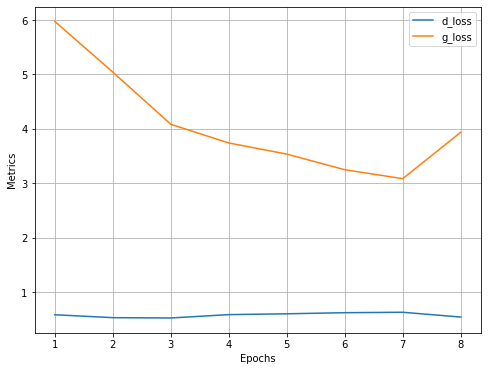

7
EPOCH: 8.000	d_loss: 0.443	g_loss: 3.676	(2923.54s - 730.88s remaining))
EPOCH: 8.000	d_loss: 0.431	g_loss: 3.159	(2924.42s - 731.11s remaining))
EPOCH: 8.000	d_loss: 0.465	g_loss: 3.449	(2925.31s - 731.33s remaining))
EPOCH: 8.000	d_loss: 0.503	g_loss: 3.136	(2926.19s - 731.55s remaining))
EPOCH: 8.000	d_loss: 0.519	g_loss: 3.368	(2927.08s - 731.77s remaining))
EPOCH: 8.000	d_loss: 0.510	g_loss: 3.326	(2927.97s - 731.99s remaining))
EPOCH: 8.000	d_loss: 0.514	g_loss: 3.289	(2928.85s - 732.21s remaining))
EPOCH: 8.000	d_loss: 0.502	g_loss: 3.202	(2929.74s - 732.44s remaining))
EPOCH: 8.000	d_loss: 0.484	g_loss: 3.235	(2930.63s - 732.66s remaining))
EPOCH: 8.000	d_loss: 0.481	g_loss: 3.182	(2931.52s - 732.88s remaining))
EPOCH: 8.000	d_loss: 0.484	g_loss: 3.194	(2932.40s - 733.10s remaining))
EPOCH: 8.000	d_loss: 0.483	g_loss: 3.131	(2933.28s - 733.32s remaining))
EPOCH: 8.000	d_loss: 0.482	g_loss: 3.148	(2934.17s - 733.54s remaining))
EPOCH: 8.000	d_loss: 0.474	g_loss: 3.189	(2935.05

EPOCH: 8.000	d_loss: 0.614	g_loss: 3.073	(3024.15s - 756.04s remaining))
EPOCH: 8.000	d_loss: 0.612	g_loss: 3.072	(3025.03s - 756.26s remaining))
EPOCH: 8.000	d_loss: 0.612	g_loss: 3.062	(3025.92s - 756.48s remaining))
EPOCH: 8.000	d_loss: 0.612	g_loss: 3.068	(3026.81s - 756.70s remaining))
EPOCH: 8.000	d_loss: 0.612	g_loss: 3.057	(3027.71s - 756.93s remaining))
EPOCH: 8.000	d_loss: 0.613	g_loss: 3.069	(3028.60s - 757.15s remaining))
EPOCH: 8.000	d_loss: 0.611	g_loss: 3.070	(3029.50s - 757.37s remaining))
EPOCH: 8.000	d_loss: 0.609	g_loss: 3.066	(3030.38s - 757.59s remaining))
EPOCH: 8.000	d_loss: 0.608	g_loss: 3.070	(3031.27s - 757.82s remaining))
EPOCH: 8.000	d_loss: 0.607	g_loss: 3.063	(3032.15s - 758.04s remaining))
EPOCH: 8.000	d_loss: 0.606	g_loss: 3.063	(3033.05s - 758.26s remaining))
EPOCH: 8.000	d_loss: 0.604	g_loss: 3.059	(3033.95s - 758.49s remaining))
EPOCH: 8.000	d_loss: 0.604	g_loss: 3.055	(3034.84s - 758.71s remaining))
EPOCH: 8.000	d_loss: 0.603	g_loss: 3.042	(3035.72s 

EPOCH: 8.000	d_loss: 0.641	g_loss: 3.017	(3125.08s - 781.27s remaining))
EPOCH: 8.000	d_loss: 0.640	g_loss: 3.020	(3125.96s - 781.49s remaining))
EPOCH: 8.000	d_loss: 0.641	g_loss: 3.011	(3126.86s - 781.71s remaining))
EPOCH: 8.000	d_loss: 0.642	g_loss: 3.017	(3127.74s - 781.94s remaining))
EPOCH: 8.000	d_loss: 0.641	g_loss: 3.017	(3128.64s - 782.16s remaining))
EPOCH: 8.000	d_loss: 0.640	g_loss: 3.012	(3129.53s - 782.38s remaining))
EPOCH: 8.000	d_loss: 0.640	g_loss: 3.020	(3130.41s - 782.60s remaining))
EPOCH: 8.000	d_loss: 0.640	g_loss: 3.016	(3131.30s - 782.82s remaining))
EPOCH: 8.000	d_loss: 0.639	g_loss: 3.012	(3132.20s - 783.05s remaining))
EPOCH: 8.000	d_loss: 0.638	g_loss: 3.019	(3133.08s - 783.27s remaining))
EPOCH: 8.000	d_loss: 0.638	g_loss: 3.013	(3133.96s - 783.49s remaining))
EPOCH: 8.000	d_loss: 0.637	g_loss: 3.012	(3134.85s - 783.71s remaining))
EPOCH: 8.000	d_loss: 0.636	g_loss: 3.011	(3135.74s - 783.94s remaining))
EPOCH: 8.000	d_loss: 0.635	g_loss: 3.010	(3136.63s 

EPOCH: 8.000	d_loss: 0.666	g_loss: 3.033	(3227.37s - 806.84s remaining)
EPOCH: 8.000	d_loss: 0.666	g_loss: 3.029	(3228.28s - 807.07s remaining)
EPOCH: 8.000	d_loss: 0.666	g_loss: 3.032	(3229.22s - 807.30s remaining)
EPOCH: 8.000	d_loss: 0.667	g_loss: 3.028	(3230.15s - 807.54s remaining)
EPOCH: 8.000	d_loss: 0.667	g_loss: 3.029	(3231.06s - 807.76s remaining)
EPOCH: 8.000	d_loss: 0.667	g_loss: 3.026	(3231.97s - 807.99s remaining)
EPOCH: 8.000	d_loss: 0.667	g_loss: 3.029	(3232.88s - 808.22s remaining)
EPOCH: 8.000	d_loss: 0.666	g_loss: 3.029	(3233.81s - 808.45s remaining)
EPOCH: 8.000	d_loss: 0.666	g_loss: 3.028	(3234.73s - 808.68s remaining)
EPOCH: 8.000	d_loss: 0.665	g_loss: 3.028	(3235.65s - 808.91s remaining)
EPOCH: 8.000	d_loss: 0.665	g_loss: 3.025	(3236.57s - 809.14s remaining)
EPOCH: 8.000	d_loss: 0.665	g_loss: 3.026	(3237.49s - 809.37s remaining)
EPOCH: 8.000	d_loss: 0.664	g_loss: 3.026	(3238.41s - 809.60s remaining)
EPOCH: 8.000	d_loss: 0.663	g_loss: 3.025	(3239.33s - 809.83s rem

 74%|███████▍  | 82/111 [00:00<00:00, 402.35it/s]

EPOCH: 8.000	d_loss: 0.641	g_loss: 2.992	(3324.63s - 831.16s remaining)


100%|██████████| 111/111 [00:00<00:00, 421.35it/s]


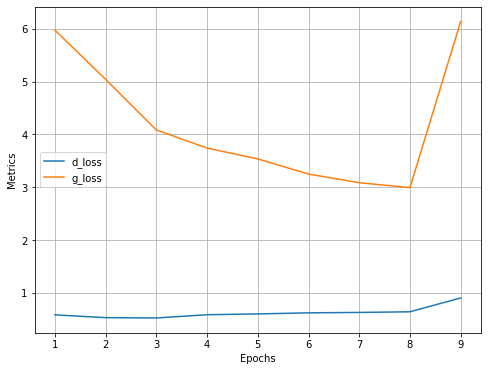

8
EPOCH: 9.000	d_loss: 1.290	g_loss: 3.138	(3326.18s - 369.58s remaining)
EPOCH: 9.000	d_loss: 1.944	g_loss: 5.028	(3327.09s - 369.68s remaining)
EPOCH: 9.000	d_loss: 2.243	g_loss: 4.401	(3328.02s - 369.78s remaining)
EPOCH: 9.000	d_loss: 1.959	g_loss: 4.299	(3328.93s - 369.88s remaining)
EPOCH: 9.000	d_loss: 1.719	g_loss: 4.037	(3329.84s - 369.98s remaining)
EPOCH: 9.000	d_loss: 1.597	g_loss: 3.862	(3330.77s - 370.09s remaining)
EPOCH: 9.000	d_loss: 1.477	g_loss: 3.755	(3331.70s - 370.19s remaining)
EPOCH: 9.000	d_loss: 1.382	g_loss: 3.580	(3332.61s - 370.29s remaining)
EPOCH: 9.000	d_loss: 1.309	g_loss: 3.697	(3333.57s - 370.40s remaining)
EPOCH: 9.000	d_loss: 1.290	g_loss: 3.439	(3334.50s - 370.50s remaining)
EPOCH: 9.000	d_loss: 1.287	g_loss: 3.634	(3335.42s - 370.60s remaining)
EPOCH: 9.000	d_loss: 1.266	g_loss: 3.563	(3336.34s - 370.70s remaining)
EPOCH: 9.000	d_loss: 1.212	g_loss: 3.545	(3337.26s - 370.81s remaining)
EPOCH: 9.000	d_loss: 1.159	g_loss: 3.590	(3338.18s - 370.91s r

EPOCH: 9.000	d_loss: 0.680	g_loss: 2.986	(3430.68s - 381.19s remaining)
EPOCH: 9.000	d_loss: 0.677	g_loss: 2.988	(3431.59s - 381.29s remaining)
EPOCH: 9.000	d_loss: 0.675	g_loss: 2.981	(3432.51s - 381.39s remaining)
EPOCH: 9.000	d_loss: 0.674	g_loss: 2.988	(3433.45s - 381.49s remaining)
EPOCH: 9.000	d_loss: 0.673	g_loss: 2.981	(3434.36s - 381.60s remaining)
EPOCH: 9.000	d_loss: 0.671	g_loss: 2.986	(3435.28s - 381.70s remaining)
EPOCH: 9.000	d_loss: 0.669	g_loss: 2.985	(3436.19s - 381.80s remaining)
EPOCH: 9.000	d_loss: 0.667	g_loss: 2.977	(3437.10s - 381.90s remaining)
EPOCH: 9.000	d_loss: 0.666	g_loss: 2.993	(3438.01s - 382.00s remaining)
EPOCH: 9.000	d_loss: 0.670	g_loss: 2.975	(3438.94s - 382.10s remaining)
EPOCH: 9.000	d_loss: 0.675	g_loss: 2.997	(3439.85s - 382.21s remaining)
EPOCH: 9.000	d_loss: 0.677	g_loss: 2.991	(3440.77s - 382.31s remaining)
EPOCH: 9.000	d_loss: 0.677	g_loss: 2.999	(3441.69s - 382.41s remaining)
EPOCH: 9.000	d_loss: 0.675	g_loss: 2.996	(3442.61s - 382.51s rem

EPOCH: 9.000	d_loss: 0.624	g_loss: 2.992	(3535.18s - 392.80s remaining)
EPOCH: 9.000	d_loss: 0.623	g_loss: 2.992	(3536.08s - 392.90s remaining)
EPOCH: 9.000	d_loss: 0.622	g_loss: 2.989	(3537.01s - 393.00s remaining)
EPOCH: 9.000	d_loss: 0.622	g_loss: 2.985	(3537.95s - 393.11s remaining)
EPOCH: 9.000	d_loss: 0.622	g_loss: 2.993	(3538.90s - 393.21s remaining)
EPOCH: 9.000	d_loss: 0.624	g_loss: 2.987	(3539.86s - 393.32s remaining)
EPOCH: 9.000	d_loss: 0.625	g_loss: 2.993	(3540.78s - 393.42s remaining)
EPOCH: 9.000	d_loss: 0.625	g_loss: 2.991	(3541.69s - 393.52s remaining)
EPOCH: 9.000	d_loss: 0.624	g_loss: 2.993	(3542.60s - 393.62s remaining)
EPOCH: 9.000	d_loss: 0.623	g_loss: 2.992	(3543.51s - 393.72s remaining)
EPOCH: 9.000	d_loss: 0.622	g_loss: 2.990	(3544.43s - 393.83s remaining)
EPOCH: 9.000	d_loss: 0.622	g_loss: 2.994	(3545.35s - 393.93s remaining)
EPOCH: 9.000	d_loss: 0.622	g_loss: 2.991	(3546.26s - 394.03s remaining)
EPOCH: 9.000	d_loss: 0.622	g_loss: 2.992	(3547.17s - 394.13s rem

EPOCH: 9.000	d_loss: 0.633	g_loss: 2.997	(3639.60s - 404.40s remaining)
EPOCH: 9.000	d_loss: 0.633	g_loss: 2.997	(3640.52s - 404.50s remaining)
EPOCH: 9.000	d_loss: 0.632	g_loss: 2.995	(3641.40s - 404.60s remaining)
EPOCH: 9.000	d_loss: 0.632	g_loss: 2.994	(3642.32s - 404.70s remaining)
EPOCH: 9.000	d_loss: 0.631	g_loss: 2.993	(3643.22s - 404.80s remaining)
EPOCH: 9.000	d_loss: 0.631	g_loss: 2.994	(3644.13s - 404.90s remaining)
EPOCH: 9.000	d_loss: 0.630	g_loss: 2.992	(3645.01s - 405.00s remaining)
EPOCH: 9.000	d_loss: 0.629	g_loss: 2.992	(3645.93s - 405.10s remaining)
EPOCH: 9.000	d_loss: 0.629	g_loss: 2.988	(3646.83s - 405.20s remaining)
EPOCH: 9.000	d_loss: 0.629	g_loss: 2.992	(3647.75s - 405.31s remaining)
EPOCH: 9.000	d_loss: 0.629	g_loss: 2.990	(3648.67s - 405.41s remaining)
EPOCH: 9.000	d_loss: 0.629	g_loss: 2.990	(3649.58s - 405.51s remaining)
EPOCH: 9.000	d_loss: 0.629	g_loss: 2.991	(3650.49s - 405.61s remaining)
EPOCH: 9.000	d_loss: 0.628	g_loss: 2.990	(3651.42s - 405.71s rem

 31%|███       | 34/111 [00:00<00:00, 334.30it/s]

EPOCH: 9.000	d_loss: 0.634	g_loss: 2.991	(3734.71s - 414.97s remaining)


100%|██████████| 111/111 [00:00<00:00, 338.31it/s]


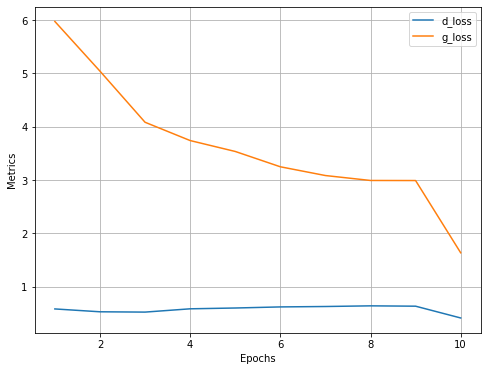

9
EPOCH: 10.000	d_loss: 0.522	g_loss: 2.950	(3736.25s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.566	g_loss: 2.589	(3737.16s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.530	g_loss: 2.827	(3738.05s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.486	g_loss: 2.841	(3738.95s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.464	g_loss: 2.705	(3739.85s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.471	g_loss: 2.867	(3740.73s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.506	g_loss: 2.663	(3741.61s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.546	g_loss: 2.929	(3742.49s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.585	g_loss: 2.769	(3743.40s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.610	g_loss: 2.938	(3744.29s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.628	g_loss: 2.901	(3745.20s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.621	g_loss: 2.967	(3746.09s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.602	g_loss: 3.002	(3746.98s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.583	g_loss: 3.035	(3747.87s - 0.00s re

EPOCH: 10.000	d_loss: 0.463	g_loss: 2.939	(3839.09s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.462	g_loss: 2.938	(3839.97s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.461	g_loss: 2.935	(3840.88s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.461	g_loss: 2.940	(3841.80s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.461	g_loss: 2.930	(3842.69s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.463	g_loss: 2.949	(3843.61s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.469	g_loss: 2.930	(3844.51s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.479	g_loss: 2.959	(3845.42s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.488	g_loss: 2.939	(3846.32s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.501	g_loss: 2.989	(3847.24s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.533	g_loss: 2.969	(3848.15s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.545	g_loss: 2.999	(3849.06s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.558	g_loss: 2.978	(3850.01s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.577	g_loss: 3.000	(3850.91s - 0.00s rema

EPOCH: 10.000	d_loss: 0.587	g_loss: 2.921	(3942.51s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.587	g_loss: 2.916	(3943.43s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.586	g_loss: 2.917	(3944.34s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.585	g_loss: 2.916	(3945.27s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.584	g_loss: 2.911	(3946.19s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.584	g_loss: 2.918	(3947.10s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.583	g_loss: 2.916	(3948.00s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.583	g_loss: 2.915	(3948.91s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.582	g_loss: 2.921	(3949.82s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.581	g_loss: 2.917	(3950.75s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.581	g_loss: 2.916	(3951.66s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.580	g_loss: 2.920	(3952.57s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.579	g_loss: 2.919	(3953.48s - 0.00s remaining))
EPOCH: 10.000	d_loss: 0.579	g_loss: 2.916	(3954.38s - 0.00s rema

EPOCH: 10.000	d_loss: 0.597	g_loss: 2.943	(4046.40s - 0.00s remaining)
EPOCH: 10.000	d_loss: 0.597	g_loss: 2.946	(4047.31s - 0.00s remaining)
EPOCH: 10.000	d_loss: 0.597	g_loss: 2.941	(4048.25s - 0.00s remaining)
EPOCH: 10.000	d_loss: 0.598	g_loss: 2.948	(4049.19s - 0.00s remaining)
EPOCH: 10.000	d_loss: 0.600	g_loss: 2.945	(4050.10s - 0.00s remaining)
EPOCH: 10.000	d_loss: 0.599	g_loss: 2.944	(4051.01s - 0.00s remaining)
EPOCH: 10.000	d_loss: 0.599	g_loss: 2.945	(4051.94s - 0.00s remaining)
EPOCH: 10.000	d_loss: 0.599	g_loss: 2.943	(4052.87s - 0.00s remaining)
EPOCH: 10.000	d_loss: 0.598	g_loss: 2.945	(4053.82s - 0.00s remaining)
EPOCH: 10.000	d_loss: 0.598	g_loss: 2.945	(4054.73s - 0.00s remaining)
EPOCH: 10.000	d_loss: 0.597	g_loss: 2.944	(4055.63s - 0.00s remaining)
EPOCH: 10.000	d_loss: 0.597	g_loss: 2.942	(4056.55s - 0.00s remaining)
EPOCH: 10.000	d_loss: 0.596	g_loss: 2.941	(4057.46s - 0.00s remaining)
EPOCH: 10.000	d_loss: 0.596	g_loss: 2.938	(4058.37s - 0.00s remaining)
EPOCH:

 23%|██▎       | 25/111 [00:00<00:00, 248.18it/s]

EPOCH: 10.000	d_loss: 0.627	g_loss: 2.956	(4142.04s - 0.00s remaining)


100%|██████████| 111/111 [00:00<00:00, 330.26it/s]


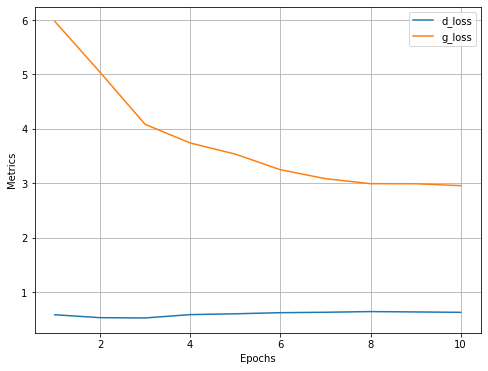

In [15]:
log = Report(10)
for epoch in range(10):
    print(epoch)
    N = len(dataloader)
    for i, images in enumerate(dataloader):
        real_data = images.to(device)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        fake_data = fake_data.detach()
        d_loss = discriminator_train_step(real_data, fake_data)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        g_loss = generator_train_step(fake_data)
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')
        log.report_avgs(epoch+1)
    log.plot_epochs(['d_loss','g_loss'])

训练过程完成后，使用以下代码生成图像样本：

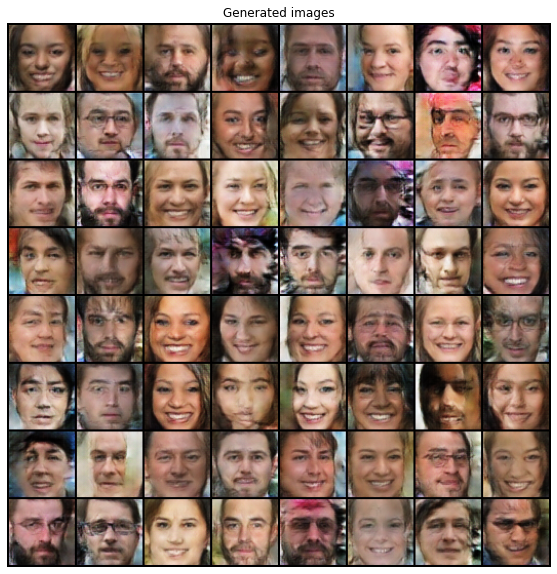

In [16]:
generator.eval()
noise = torch.randn(64, 100, 1, 1, device=device)
sample_images = generator(noise).detach().cpu()
grid = vutils.make_grid(sample_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=10, title='Generated images')